# Backtesting: EW vs CW

In [1]:
import numpy as np
import pandas as pd
import edhec_risk_kit as erk

%load_ext autoreload
%autoreload 2

In [2]:
ind49_rets = erk.get_ind_returns(weighting='vw', n_inds=49)['1974':]
ind49_mcap = erk.get_ind_market_caps(49, weights=True)['1974':]

In this section, we develop a basic infrastructure to backtest various portfolio construction techniques and compare them. 

First, we will write trivially simple weight-optimizers for equally weighted and cap weighted portfolios and compare them. There are no covariance estimates required for either of these weighting schemes. In future, we'll enhance these optimizers to use more complex weighting schemes that will rely on covariance estimates.

In [6]:
def weight_ew(r, **kwargs):
    '''
    Returns the weights of the EW portfolio based on the asset returns 'r' as a DataFrame
    '''
    n = len(r.columns)
    return pd.Series(1/n, index=r.columns)


def weight_cw(r, cap_weights, **kwargs):
    '''
    Returns the weights of the CW potfolio based on the time series of cap weights
    '''
    return cap_weights.loc[r.index[0]]


def backtest_ws(r, estimation_window=60, weighting=weight_ew, **kwargs):
    '''
    Backtests a given weighting scheme, given some parameters:
        r: asset returns to use to build the portfolio
        estimation_window: the window to use to estimate parameters
        weighting: the weighting scheme to use, must be a function that takes 'r' and a variable number of parameters
    '''
    n_periods = r.shape[0]
    windows = [(start, start+estimation_window) for start in range(n_periods-estimation_window+1)]
    weights = [weighting(r.iloc[win[0]:win[1]], **kwargs) for win in windows]
    # turn list into dataframe
    weights = pd.DataFrame(weights, index=r.iloc[estimation_window-1:].index, columns=r.columns)
    returns = (weights*r).sum(axis=1, min_count=1)
    return returns

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
EW,0.123921,0.160660,-0.759092,6.659028,0.071404,0.102331,0.568799,-0.528292
CW,0.120165,0.147544,-0.717960,5.562648,0.065636,0.093769,0.594625,-0.515999


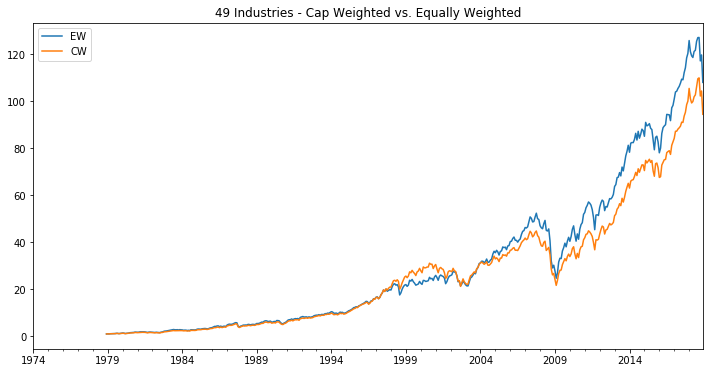

In [7]:
ewr = backtest_ws(ind49_rets, weighting=weight_ew)
cwr = backtest_ws(ind49_rets, weighting=weight_cw, cap_weights=ind49_mcap)
btr = pd.DataFrame({
    'EW': ewr,
    'CW': cwr
})
(1+btr).cumprod().plot(figsize=(12, 6), title='49 Industries - Cap Weighted vs. Equally Weighted')
erk.summary_stats(btr.dropna())

## Improving EW with CapWeight Tethering
In practice, we'll want to implement some sort of a modification of a pure strategy. Constraints for an equal weighted portfolio:
1. Micocap stocks could be overweighted so need to be compensated for
2. Sector weights of the cap-weighted benchmark can be matched

Benefits of making compensations:
1. Makes a portfolio more tradeable (some microcaps may not have the requisite liquidity)
2. Improves the tracking error to the cap-weighted index

To illustrate, we enhance our `weight_ew` allocator:
1. Drop microcap stocks beyond a particular threshold
2. Impose a constraint that ensures that the maximum weight assigned to any stock is no more than some multiple of weight it would be in a cap-weighted portfolio

In [19]:
def weight_ew(r, cap_weights=None, max_cw_mult=None, microcap_threshold=None, **kwargs):
    '''
    Returns the weights of the EW portfolio based on the asset returns 'r' as a DataFrame
    If supplied a set of Cap Weights and a Cap Weight tether, it is applied and reweighted
    '''
    n = len(r.columns)
    ew = pd.Series(1/n, index=r.columns)
    if cap_weights is not None:
        cw = cap_weights.loc[r.index[0]]
        # exclude microcaps
        if microcap_threshold is not None and microcap_threshold > 0:
            microcap = cw < microcap_threshold
            ew[microcap] = 0
            ew = ew/ew.sum()
        # limit weight to a multiple of cap weight
        if max_cw_mult is not None and max_cw_mult > 0:
            ew = np.minimum(ew, cw*max_cw_mult)
            ew = ew/ew.sum()
    return ew


def weight_cw(r, cap_weights, **kwargs):
    '''
    Returns the weights of the CW potfolio based on the time series of cap weights
    '''
    return cap_weights.loc[r.index[0]]


def backtest_ws(r, estimation_window=60, weighting=weight_ew, **kwargs):
    '''
    Backtests a given weighting scheme, given some parameters:
        r: asset returns to use to build the portfolio
        estimation_window: the window to use to estimate parameters
        weighting: the weighting scheme to use, must be a function that takes 'r' and a variable number of parameters
    '''
    n_periods = r.shape[0]
    windows = [(start, start+estimation_window) for start in range(n_periods-estimation_window+1)]
    weights = [weighting(r.iloc[win[0]:win[1]], **kwargs) for win in windows]
    # turn list into dataframe
    weights = pd.DataFrame(weights, index=r.iloc[estimation_window-1:].index, columns=r.columns)
    returns = (weights*r).sum(axis=1, min_count=1)
    return returns

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
EW,0.123921,0.160660,-0.759092,6.659028,0.071404,0.102331,0.568799,-0.528292
EW-Tethered,0.125572,0.156923,-0.752967,6.187433,0.069778,0.099191,0.592597,-0.530654
CW,0.120165,0.147544,-0.717960,5.562648,0.065636,0.093769,0.594625,-0.515999


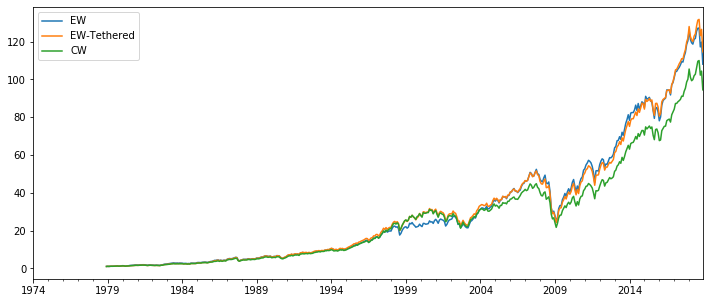

In [23]:
ewr = backtest_ws(ind49_rets)
ewtr = backtest_ws(ind49_rets, cap_weights=ind49_mcap, max_cw_mult=5, microcap_threshold=0.005)
cwr = backtest_ws(ind49_rets, weighting=weight_cw, cap_weights=ind49_mcap)
btr = pd.DataFrame({
    'EW': ewr,
    'EW-Tethered': ewtr,
    'CW': cwr
})
(1+btr).cumprod().plot(figsize=(12, 5))
erk.summary_stats(btr.dropna())